In [2]:
import os
import torch
import torch.nn as nn
import pandas as pd
from torchvision.utils import save_image
from pathlib import Path

# CONFIGURACIÓN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
timesteps = 100
betas = torch.linspace(1e-4, 0.02, timesteps).to(device)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

image_size = 64
n_imgs_target = 2000
class_counts = {"G": 260, "C": 292, "A": 242, "M": 238}

base_dir = Path("C:/Users/34629/TFG")
model_dir = Path("C:/Users/34629/Downloads/ddpm_retfound_outputs")
output_dir = base_dir / "generated_diffusion_images"
output_dir.mkdir(parents=True, exist_ok=True)

csv_path = base_dir / "single_label_dataset_without_H_no_O.csv"
new_csv_path = base_dir / "dataset_DIF.csv"

# Cargar dataset original
df = pd.read_csv(csv_path)
new_entries = []

# MODELO DE DIFUSIÓN (el mismo que usaste en entrenamiento)
class RETFoundDDPM(nn.Module):
    def __init__(self):
        super().__init__()
        base_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights=None)
        self.encoder = nn.Sequential(*list(base_model.children())[:-2])
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1)
        )
    def forward(self, x):
        x = self.encoder(x)
        return self.decoder(x)

# GENERACIÓN DE IMÁGENES Y ACTUALIZACIÓN DEL CSV
for cls, n_original in class_counts.items():
    n_to_generate = n_imgs_target - n_original
    print(f"\n🌀 Generando {n_to_generate} imágenes para la clase {cls}...")

    model = RETFoundDDPM().to(device)
    model_path = model_dir / cls / "DDPM_best_model.pt"
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    class_out_dir = output_dir / cls
    class_out_dir.mkdir(parents=True, exist_ok=True)

    for i in range(n_to_generate):
        x = torch.randn(1, 3, image_size, image_size).to(device)
        for t in reversed(range(timesteps)):
            alpha = alphas[t]
            alpha_bar = alphas_cumprod[t]
            beta = betas[t]
            pred_noise = model(x)
            x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / torch.sqrt(1 - alpha_bar)) * pred_noise)
            if t > 0:
                x += torch.sqrt(beta) * torch.randn_like(x)

        img_path = class_out_dir / f"img_{cls}_{i:04d}.png"
        save_image(x[0], img_path, normalize=True)

        new_row = {"Image_Path": str(img_path).replace("\\", "/")}
        for col in ['N', 'D', 'G', 'C', 'A', 'M', 'O']:
            new_row[col] = 1 if col == cls else 0
        new_entries.append(new_row)

# GUARDAR NUEVO CSV
df_new = pd.DataFrame(new_entries)
df_combined = pd.concat([df, df_new], ignore_index=True)
df_combined.to_csv(new_csv_path, index=False)

print("\n✅ Imágenes generadas y CSV guardado como 'dataset_DIF.csv'")



🌀 Generando 1740 imágenes para la clase G...


Using cache found in C:\Users\34629/.cache\torch\hub\pytorch_vision_v0.10.0



🌀 Generando 1708 imágenes para la clase C...


Using cache found in C:\Users\34629/.cache\torch\hub\pytorch_vision_v0.10.0



🌀 Generando 1758 imágenes para la clase A...


Using cache found in C:\Users\34629/.cache\torch\hub\pytorch_vision_v0.10.0



🌀 Generando 1762 imágenes para la clase M...


Using cache found in C:\Users\34629/.cache\torch\hub\pytorch_vision_v0.10.0



✅ Imágenes generadas y CSV guardado como 'dataset_DIF.csv'


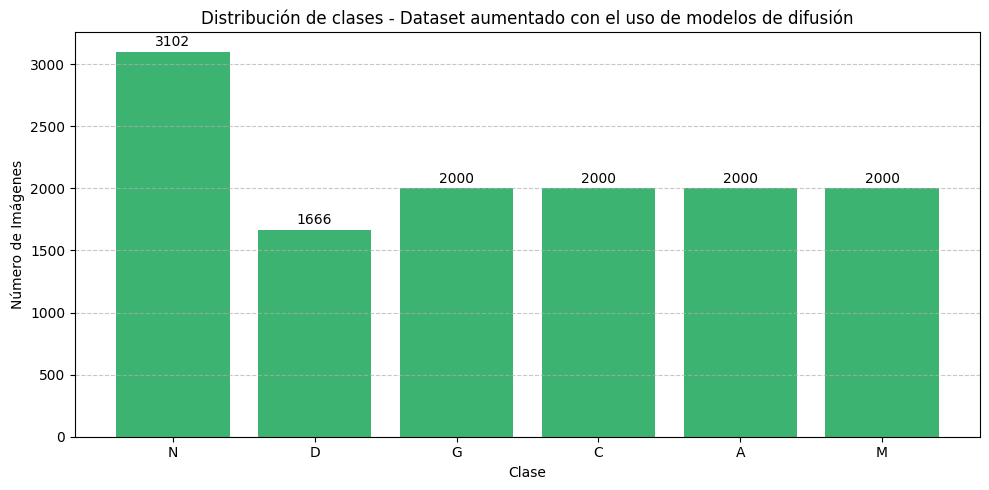

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datasets
df_augmented_filtered = pd.read_csv("C:/Users/34629/TFG/dataset_DIF.csv")

# Columnas de clases
filtered_classes = ['N', 'D', 'G', 'C', 'A', 'M']

# Contar ocurrencias por clase
counts_augmented_filtered = df_augmented_filtered[filtered_classes].sum()

# Función para generar el gráfico con etiquetas sobre cada barra
def plot_distribution(counts, title, color):
    plt.figure(figsize=(10, 5))
    bars = plt.bar(counts.index, counts.values, color=color)
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 20, f'{int(height)}',
                 ha='center', va='bottom', fontsize=10)
    plt.title(title, fontsize=12)
    plt.xlabel('Clase')
    plt.ylabel('Número de Imágenes')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Dibujar los gráficos
plot_distribution(counts_augmented_filtered, 'Distribución de clases - Dataset aumentado con el uso de modelos de difusión', 'mediumseagreen')
